## Shortlist Promising Models - SGD Classifier

#### 0. Import modules and define parameters

In [1]:
import sys
sys.path.append("..")

from module.utils import general_utils
from module.utils import data_prepare_utils
from module.utils import model_performance_utils
import module.utils.bin_class_utils as bin_class_utils

from sklearn.linear_model import SGDClassifier

from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
target_attr = "label"
target_type = "binary"

estimator_name = "SGDClassifier"

sample_random_state = 24
target_encoding_random_state = 42
model_random_state = 42
loss = 'log_loss'
permutation_importance_random_state = 0
train_validation_split_random_state = 24

#### 1. Import Data

In [3]:
train_df = pd.read_csv('train_df_exp.csv')
train_df

,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1266565,2325,4456,6,139,60,3,17,78,23,...,4,20,-1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,12,38,7,0
1,2003072,3456,3720,7,107,15,5,15,46,39,...,2,18,-1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,12,36,3,0
2,1648461,3854,3367,7,207,17,5,14,13,37,...,5,20,1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,17,5,0
3,1829479,3330,6897,7,133,37,5,13,34,13,...,4,20,1,-1,2,1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^1...,12,17,1,0
4,2139990,1464,5117,7,119,60,5,12,57,27,...,3,16,-1,-1,2,5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^...,11,24,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6699,1370406,5183,5668,7,104,37,5,13,50,37,...,4,20,-1,-1,10,8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,9,17,7,0
6700,2126988,3420,4680,8,142,36,5,12,80,41,...,2,-1,-1,-1,2,1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^1...,12,42,1,0
6701,1440508,5295,2402,7,147,29,5,12,86,37,...,4,-1,-1,-1,2,8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,8,17,4,0
6702,2214417,1007,6572,7,145,46,5,17,43,37,...,3,20,-1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,12,27,6,0


In [4]:
train_cap_x_df, train_y_df = train_df.drop(columns=target_attr), train_df[[target_attr]]

In [5]:
print('Distribution in train_y_df\n', train_y_df.value_counts(normalize=True), '\n')

Distribution in train_y_df
 label
0        0.965543
1        0.034457
Name: proportion, dtype: float64 



#### 3. Check attribute types

In [6]:
numerical_attr_list = []
categorical_attr_list = [attr for attr in train_df.columns if attr not in numerical_attr_list and attr != target_attr]
attr_list = numerical_attr_list + categorical_attr_list

#### ! Unbalance
- Assess unbalance: Based on the distribution printed above, the distribution is unbalanced. 
- Steps to deal with unbalanced classes

In [7]:
# possible options for class_weight hyperparameter
balanced = train_y_df.shape[0] / (train_y_df[target_attr].nunique()*np.bincount(train_y_df[target_attr]))
balanced_dict = \
    dict(
        zip(
            train_y_df[target_attr].unique(), 
            balanced
        )
    )
balanced_and_normalized_dict = \
    dict(
        zip(
            train_y_df[target_attr].unique(),
            balanced/sum(balanced)
            )
        )
class_weight_options_dict = {
    'None': None,
    'balanced mode': 'balanced',
    'balanced computed': balanced_dict,
    'balanced_and_normalized': balanced_and_normalized_dict
}

#### 4. Predefined data processing strategy in prep.ipynb

In [8]:
attrs_to_drop = ['app_score', 'his_on_shelf_time', 'task_id', 'spread_app_id', 'tags', 'dev_id', 'app_second_class', 'adv_prim_id', 'device_price']


preprocessor = bin_class_utils.build_preprocessing_pipeline(numerical_attr_list, categorical_attr_list, attrs_to_drop, target_type, target_encoding_random_state)

#### 5. Define default model

In [9]:
estimator = SGDClassifier(loss=loss, random_state=model_random_state)

#### 6. Define composite model

In [10]:
composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])

In [11]:
composite_estimator.fit(
    train_cap_x_df,
    train_y_df.values.ravel()
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropColumnsTransformer(attrs_to_drop=['app_score',
                                                                                                         'his_on_shelf_time',
                                                                                                         'task_id',
                                                                                                         'spread_app_id',
                                                                                                         'tags',
                                                                                                         'dev_id',
                                                                                                         'app_second_class',
                                                                                                         'adv_prim_id',
                                                                                                         'device_price'])),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('categorical'...
                                                   'app_first_class',
                                                   'app_second_class', 'age',
                                                   'city', 'city_rank',
                                                   'device_name', 'device_size',
                                                   'career', 'gender',
                                                   'net_type', 'residence',
                                                   'his_app_size',
                                                   'his_on_shelf_time',
                                                   'app_score', 'emui_dev',
                                                   'list_time', 'device_price',
                                                   'up_life_duration',
                                                   'up_membership_grade',
                                                   'membership_life_duration', ...])])),
                ('estimator', SGDClassifier(loss='log_loss', random_state=42))])

#### 7. Check the most significant attributes

In [12]:
permutation_df = bin_class_utils.check_out_permutation_importance(
    composite_estimator, 
    train_cap_x_df, 
    train_y_df, 
    permutation_importance_random_state
)

permutation_df


Permutation importance:


,Feature,sqrt_neg_mean_squared_error


#### 8. Evaluate the performance of the trained default estimators on the train set
Based on the confusion matrix, 7976 (7976 + 0) predictions are correct and 404 (289 + 115) predictions are incorrect. - modify required

Check accuracy score
train set set accuracy score: 0.9646479713603818

Check confusion matrix
train set set confusion matrix: 
[[6467    6]
 [ 231    0]]
True Positives =  6467
True Negatives =  0
False Positives(Type I error) =  6
False Negatives(Type II error) =  231

Check classification report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      6473
           1       0.00      0.00      0.00       231

    accuracy                           0.96      6704
   macro avg       0.48      0.50      0.49      6704
weighted avg       0.93      0.96      0.95      6704


Check the ROC Curve and AUC


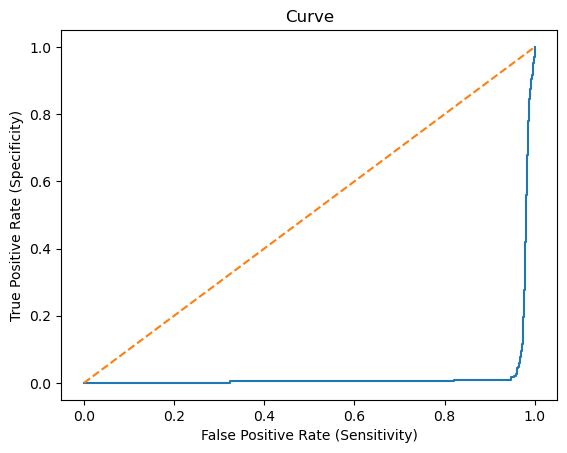


Check Precision-Recall Curve and Average Precision Score


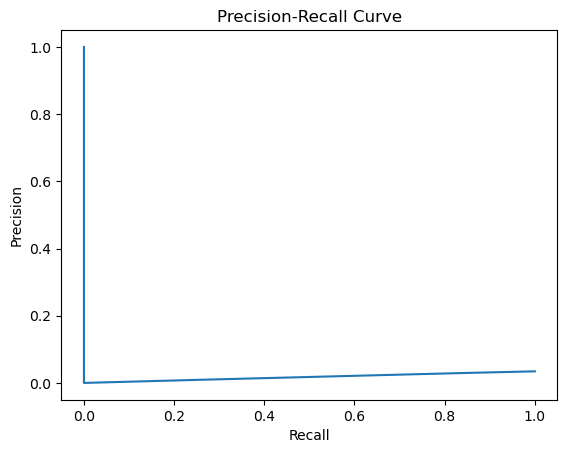

The roc_auc_score:  0.49953653638189405
Average Precision Score:  0.0177609857701742


(0.49953653638189405, 0.0177609857701742)

In [13]:
bin_class_utils.eval_class(train_cap_x_df, train_y_df, composite_estimator, 'train set')

#### 9. Performance with different class_weight hyperparameter

Check accuracy score
train sample set accuracy score: 0.9646479713603818

Check confusion matrix
train sample set confusion matrix: 
[[6467    6]
 [ 231    0]]
True Positives =  6467
True Negatives =  0
False Positives(Type I error) =  6
False Negatives(Type II error) =  231

Check classification report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      6473
           1       0.00      0.00      0.00       231

    accuracy                           0.96      6704
   macro avg       0.48      0.50      0.49      6704
weighted avg       0.93      0.96      0.95      6704


Check the ROC Curve and AUC


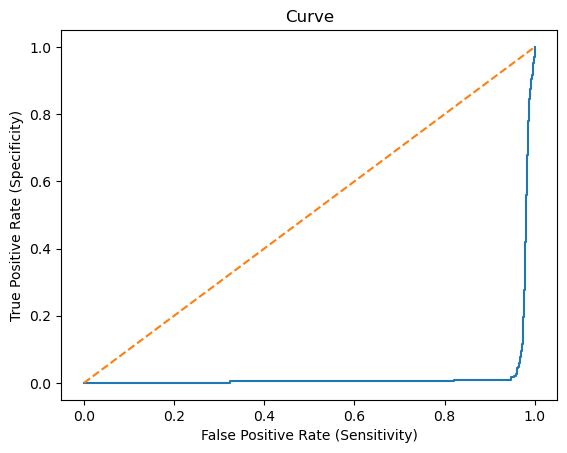


Check Precision-Recall Curve and Average Precision Score


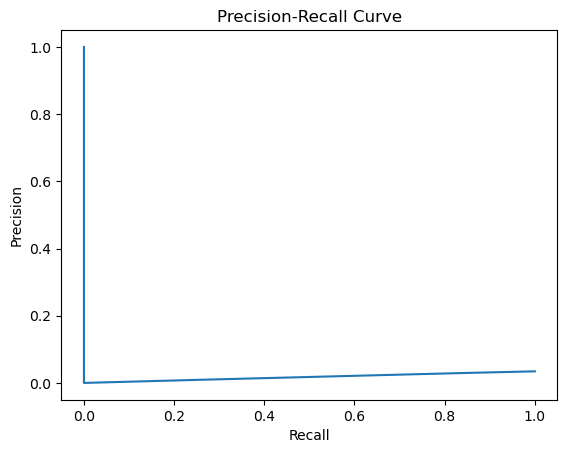

The roc_auc_score:  0.49953653638189405
Average Precision Score:  0.0177609857701742
Check accuracy score
train sample set accuracy score: 0.5380369928400954

Check confusion matrix
train sample set confusion matrix: 
[[3595 2878]
 [ 219   12]]
True Positives =  3595
True Negatives =  12
False Positives(Type I error) =  2878
False Negatives(Type II error) =  219

Check classification report
              precision    recall  f1-score   support

           0       0.94      0.56      0.70      6473
           1       0.00      0.05      0.01       231

    accuracy                           0.54      6704
   macro avg       0.47      0.30      0.35      6704
weighted avg       0.91      0.54      0.68      6704


Check the ROC Curve and AUC


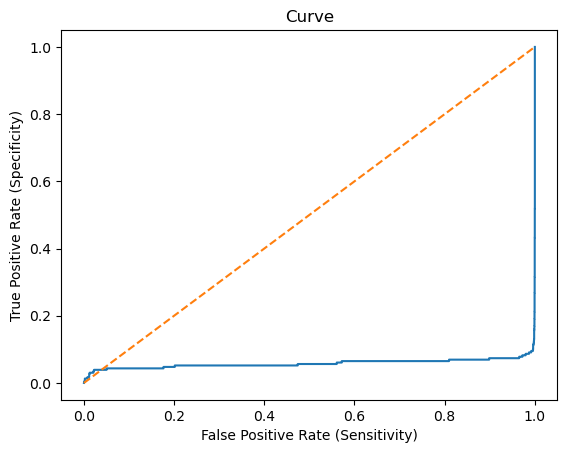


Check Precision-Recall Curve and Average Precision Score


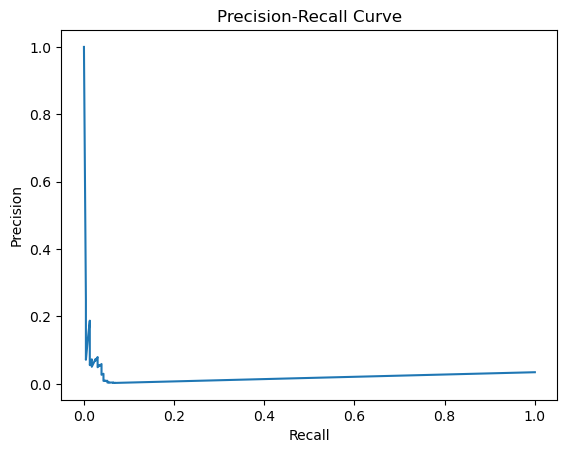

The roc_auc_score:  0.3036659771558582
Average Precision Score:  0.021912428849858487
Check accuracy score
train sample set accuracy score: 0.5380369928400954

Check confusion matrix
train sample set confusion matrix: 
[[3595 2878]
 [ 219   12]]
True Positives =  3595
True Negatives =  12
False Positives(Type I error) =  2878
False Negatives(Type II error) =  219

Check classification report
              precision    recall  f1-score   support

           0       0.94      0.56      0.70      6473
           1       0.00      0.05      0.01       231

    accuracy                           0.54      6704
   macro avg       0.47      0.30      0.35      6704
weighted avg       0.91      0.54      0.68      6704


Check the ROC Curve and AUC


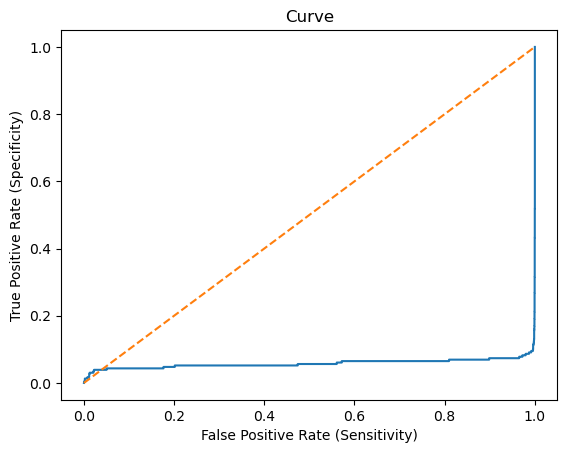


Check Precision-Recall Curve and Average Precision Score


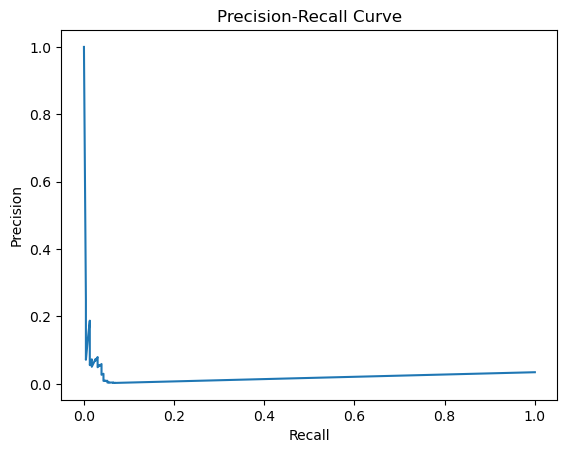

The roc_auc_score:  0.3036659771558582
Average Precision Score:  0.021912428849858487
Check accuracy score
train sample set accuracy score: 0.668854415274463

Check confusion matrix
train sample set confusion matrix: 
[[4256 2217]
 [   3  228]]
True Positives =  4256
True Negatives =  228
False Positives(Type I error) =  2217
False Negatives(Type II error) =  3

Check classification report
              precision    recall  f1-score   support

           0       1.00      0.66      0.79      6473
           1       0.09      0.99      0.17       231

    accuracy                           0.67      6704
   macro avg       0.55      0.82      0.48      6704
weighted avg       0.97      0.67      0.77      6704


Check the ROC Curve and AUC


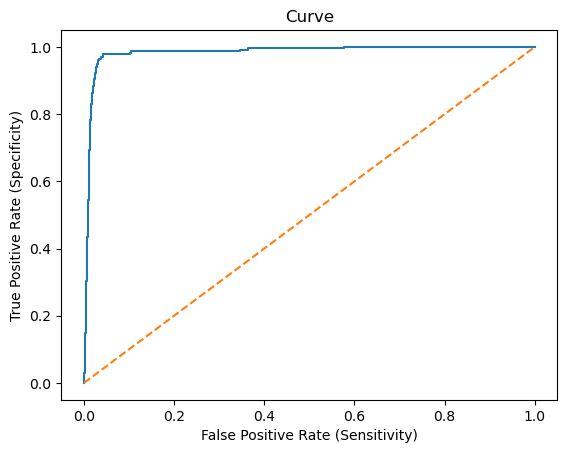


Check Precision-Recall Curve and Average Precision Score


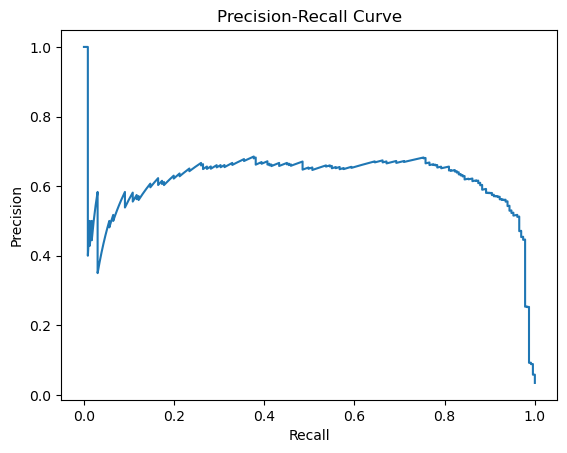

The roc_auc_score:  0.8222566866163343
Average Precision Score:  0.6201231841666435


,class_weight_name,class imbalance class 0,class imbalance class 1,roc_curve_auc,ave_precision_score,data_set
0,None,0.965543,0.034457,0.499537,0.017761,train
1,balanced mode,0.965543,0.034457,0.303666,0.021912,train
2,balanced computed,0.965543,0.034457,0.303666,0.021912,train
3,balanced_and_normalized,0.965543,0.034457,0.822257,0.620123,train


In [14]:
perf_dict_list = []

for class_weight_name, class_weight_option in class_weight_options_dict.items():
    estimator = SGDClassifier(loss=loss, random_state=model_random_state, class_weight=class_weight_option)
    
    composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])

    roc_auc, ave_precision = \
        bin_class_utils.eval_class(train_cap_x_df, train_y_df, composite_estimator, 'train sample')
    row_dict = {
        'class_weight_name': class_weight_name,
        'class imbalance class 0': train_y_df[target_attr].value_counts(normalize=True).loc[0],
        'class imbalance class 1': train_y_df[target_attr].value_counts(normalize=True).loc[1],
        'roc_curve_auc': roc_auc,
        'ave_precision_score': ave_precision,
        'data_set': 'train'
    }
    perf_dict_list.append(row_dict)
    
perf_dict_df = pd.DataFrame(perf_dict_list)
perf_dict_df

#### 10. Evaluate the performance of the trained default estimators on the validation set

In [15]:
validation_df = pd.read_csv('validation_df_exp.csv')
validation_cap_x_df, validation_y_df = validation_df.drop(columns=target_attr), validation_df[[target_attr]]

Check accuracy score
validation set set accuracy score: 1.0

Check confusion matrix
validation set set confusion matrix: 
[[1619    0]
 [   0   58]]
True Positives =  1619
True Negatives =  58
False Positives(Type I error) =  0
False Negatives(Type II error) =  0

Check classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1619
           1       1.00      1.00      1.00        58

    accuracy                           1.00      1677
   macro avg       1.00      1.00      1.00      1677
weighted avg       1.00      1.00      1.00      1677


Check the ROC Curve and AUC


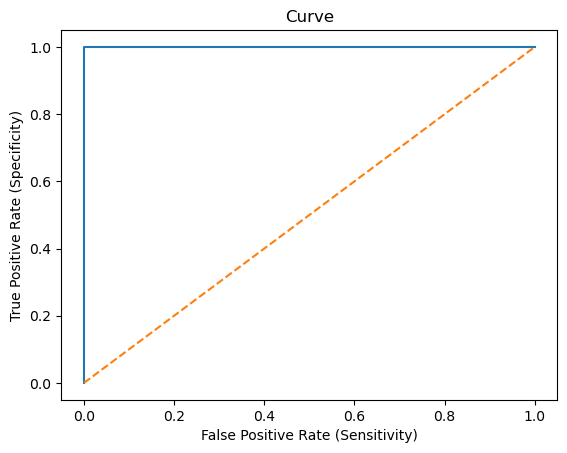


Check Precision-Recall Curve and Average Precision Score


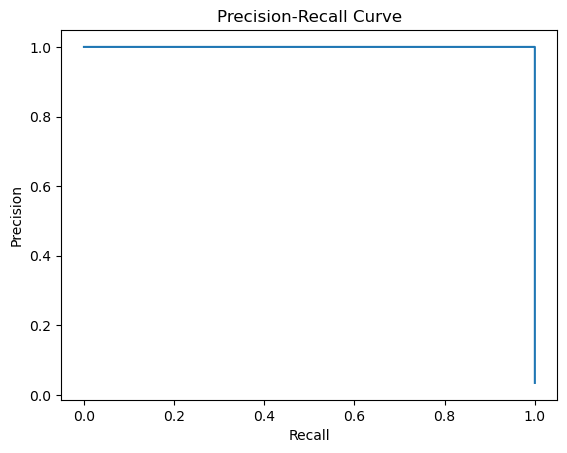

The roc_auc_score:  1.0
Average Precision Score:  1.0


In [16]:
val_estimator = SGDClassifier(loss=loss, random_state=model_random_state, class_weight=balanced_and_normalized_dict)
    
val_composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', val_estimator)])

val_roc_auc, val_ave_precision = \
    bin_class_utils.eval_class(validation_cap_x_df, validation_y_df, val_composite_estimator, 'validation set')
val_dict_list = {
    'class_weight_name': 'balanced_and_normalized',
    'roc_curve_auc': val_roc_auc,
    'ave_precision_score': val_ave_precision,
    'data_set': 'validation'
}
val_perf_dict_df = pd.DataFrame([val_dict_list])

In [17]:
# compare the performance on the train and validation set
uncompared_columns = ['class imbalance class 0', 'class imbalance class 1']
best_perf_dict_df = perf_dict_df[perf_dict_df['class_weight_name'] == 'balanced_and_normalized'].drop(columns = uncompared_columns)
pd.concat([best_perf_dict_df, val_perf_dict_df], ignore_index=True)

,class_weight_name,roc_curve_auc,ave_precision_score,data_set
0,balanced_and_normalized,0.822257,0.620123,train
1,balanced_and_normalized,1.000000,1.000000,validation


#### Other steps